# Model optimisation
## Preparation
### A word of caution about the runtime
Please note that running this notebook in its entieriety can take around 1.5 hours or more depending on your hardware.

### Dependencies and data import

In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt

#  Import and read the charity_data.csv.
import pandas as pd 
application_df = pd.read_csv("https://static.bc-edx.com/data/dla-1-2/m21/lms/starter/charity_data.csv")

### Clean data

In [2]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=['EIN', 'NAME'])

# Choose a cutoff value of 500 and create a list of application types to be replaced
all_app_types = application_df['APPLICATION_TYPE'].value_counts().to_dict()
application_types_to_replace = [i for i in all_app_types.keys() if all_app_types[i] < 500]

# Replace in dataframe
for app in application_types_to_replace:
    application_df['APPLICATION_TYPE'] = application_df['APPLICATION_TYPE'].replace(app,"Other")

# Choose a cutoff value and create a list of classifications to be replaced
# use the variable name `classifications_to_replace`
all_class_types = application_df['CLASSIFICATION'].value_counts().to_dict()
classifications_to_replace = [i for i in all_class_types.keys() if all_class_types[i] < 1000]

# Replace in dataframe
for cls in classifications_to_replace:
    application_df['CLASSIFICATION'] = application_df['CLASSIFICATION'].replace(cls,"Other")

# Get all categorical data columns into a list
dummies_cols = []

cols = application_df.columns
typs = application_df.dtypes.values

for c in range(len(cols)):
    if (typs[c] == 'object'):
        dummies_cols.append(cols[c])

# Convert categorical data to numeric with `pd.get_dummies`
dummies_df = pd.get_dummies(application_df[dummies_cols])

# Concatenate the DF with the dummy data with the original dataset
concat_df = pd.concat([application_df, dummies_df], axis=1)

# Drop the unused columns
concat_df = concat_df.drop(columns=dummies_cols)

# Split our preprocessed data into our features and target arrays
y = concat_df['IS_SUCCESSFUL']
X = concat_df.drop(columns='IS_SUCCESSFUL')

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

### Model training and evaluation function

In [4]:
def train_and_evaluate_model(data_train, data_test, in_features, in_units, internal_layers, internal_activation, n_epochs):

    # Check the validity of the parameters
    if len(internal_layers) == len(internal_activation):

        n_hidden = len(internal_layers)
    
        nn = tf.keras.models.Sequential()

        # First hidden layer
        nn.add(tf.keras.layers.Dense(units=in_units, activation="relu", input_dim=in_features))

        # Add hidden layers
        for i in range(n_hidden):
            nn.add(tf.keras.layers.Dense(units=internal_layers[i], activation=internal_activation[i]))

        # Output layer
        nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

        # Compile the model
        nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

        # Train the model
        nn.fit(data_train['X'], data_train['y'], epochs=n_epochs,verbose=0)

        # Evaluate the model using the test data
        model_loss, model_accuracy = nn.evaluate(data_test['X'],data_test['y'],verbose=0)

        return model_loss, model_accuracy, nn
    
    else:
        print('Error: internal_layers and internal_activation must be the same length')
        print(f"internal_layers has length {len(internal_layers)}.")
        print(f"internal_activation has length {len(internal_activation)}.")
        return -1

## First model
- Input layer: 10 neurons, `relu` activation function
- Internal layer: 5 neuros, `relu` activation function
- Output layer: 1 neuron, `sigmoid` activation function
- 100 epochs

### Run first model

In [5]:
in_features = len(X.columns)
in_units = 10
internal_layers = [5]
internal_activation = ['relu']

data_train = {'X': X_train_scaled, 'y': y_train}
data_test = {'X': X_test_scaled, 'y': y_test}

n_epochs = 100

model_loss, model_accuracy, model = train_and_evaluate_model(data_train, data_test, in_features, in_units, internal_layers, internal_activation, n_epochs)

### First model performance
The performance is really close to the requirements (see below) but under the target of 75%.

In [6]:
print(f"Loss: {100*model_loss:.2f}%")
print(f"Accuracy: {100*model_accuracy:.2f}%")

Loss: 55.24%
Accuracy: 72.82%


## Second model
To improve the performance, we try and add an additional hidden layer to hopefully improve with the nonlinearities in the data. A large number of neurons are used as a first pass but this could be removed should the performance be satisfoactory to simplify the model. The `swish` activation functions are used instead of `relu` as a test. More epochs are used to give more time to train the model.
- Input layer: 10 neurons, `relu` activation function
- Internal layer 1: 20 neurons, `swish` activation function
- Internal layer 2: 20 neurons, `swish` activation function
- Internal layer 3: 20 neurons, `swish` activation function
- Output layer: 1 neuron, `sigmoid` activation function
- 200 epochs

### Strategy 1: increase the number of hidden layers
We run the model, with 1-4 hidden layers. The activation function is kept as `relu` and the number of epochs is kept at 100.

In [7]:
# Model parameters (fixed)
in_features = len(X.columns)
in_units = 10
hidden_units = 5 # Number of neurons per hidden layer
hidden_activ = 'relu' # Activation function for hidden layer
data_train = {'X': X_train_scaled, 'y': y_train}
data_test = {'X': X_test_scaled, 'y': y_test}
n_epochs = 100

# Model paramters (variable)
hidden_layers = [1, 2, 3, 4]

# Create empty list to store results
model_2_1_loss = []
model_2_1_acc = []

for h in hidden_layers:
    # Print step
    print(f"Prepare model with {h} internal layer{'s' if h>1 else ''}...")

    # Create internal layers list
    internal_layers = [hidden_units]*h
    internal_activation = [hidden_activ]*h

    # Train and evaluate model
    loss, acc, model = train_and_evaluate_model(data_train, data_test, in_features, in_units, internal_layers, internal_activation, n_epochs)

    # Add performance data to lists
    model_2_1_loss.append(loss)
    model_2_1_acc.append(acc)

Prepare model with 1 internal layer...
Prepare model with 2 internal layers...
Prepare model with 3 internal layers...
Prepare model with 4 internal layers...


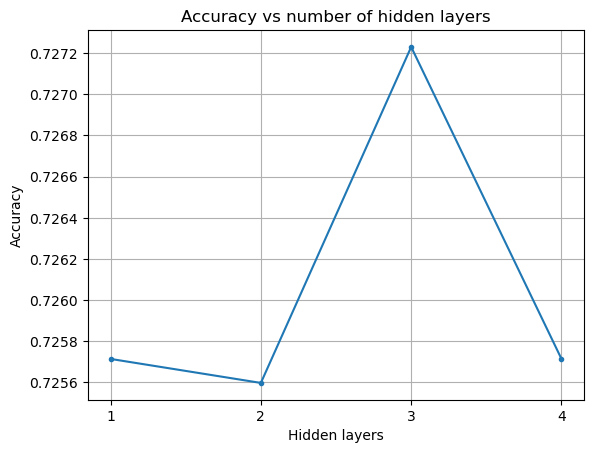

In [34]:
hidden_layers = [1, 2, 3, 4]
plt.plot(hidden_layers,model_2_1_acc, '.-')
plt.xlabel('Hidden layers')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of hidden layers')
plt.xticks([1,2,3,4],hidden_layers)
plt.grid()
plt.savefig('img/accuracy_vs_number_of_hidden_layers.png')
plt.show()

### Strategy 2: change the activation function
Based on the results above, we keep 3 hidden layers and we test different activation function for the input and hidden layers.

In [11]:
# Model parameters (fixed)
in_features = len(X.columns)
in_units = 10
hidden_units = 5 # Number of neurons per hidden layer
hidden_layers = 3 # Number of hidden layers
internal_layers = [hidden_units]*hidden_layers
data_train = {'X': X_train_scaled, 'y': y_train}
data_test = {'X': X_test_scaled, 'y': y_test}
n_epochs = 100

# Model paramters (variable)
activation_functions = ['relu', 'elu', 'selu', 'gelu', 'tanh', 'swish']

# Create empty list to store results
model_2_2_loss = []
model_2_2_acc = []

for a in activation_functions:
    # Print step
    print(f"Prepare model with '{a}' activation function...")

    # Create internal activation function list
    internal_activation = [a]*hidden_layers # Activation function for hidden layers (list)

    # Train and evaluate model
    loss, acc, model = train_and_evaluate_model(data_train, data_test, in_features, in_units, internal_layers, internal_activation, n_epochs)

    # Add performance data to lists
    model_2_2_loss.append(loss)
    model_2_2_acc.append(acc)

Prepare model with 'relu' activation function...
Prepare model with 'elu' activation function...
Prepare model with 'selu' activation function...
Prepare model with 'gelu' activation function...
Prepare model with 'tanh' activation function...
Prepare model with 'swish' activation function...


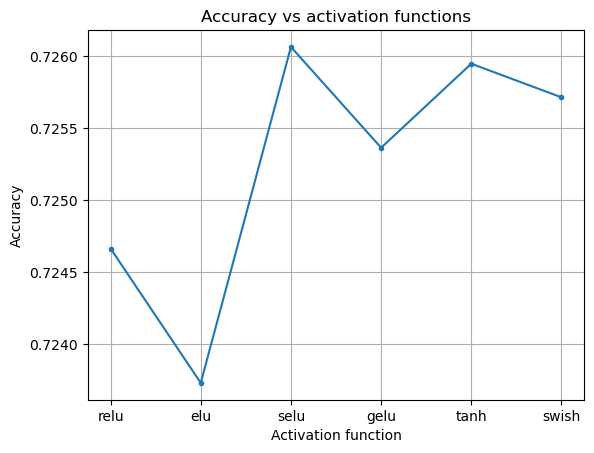

In [35]:
plt.plot(activation_functions,model_2_2_acc, '.-')
plt.xlabel('Activation function')
plt.ylabel('Accuracy')
plt.title('Accuracy vs activation functions')
plt.grid()
plt.savefig('img/accuracy_vs_activation_functions.png')
plt.show()

### Strategy 3: change the number of neurons per layer
Based on the results above, we use `selu` as the activation function and we test different number of neurons per layers to account for more or less variability in the data.

In [24]:
# Model parameters (fixed)
in_features = len(X.columns)
hidden_layers = 3 # Number of hidden layers
internal_activation = ['selu']*hidden_layers
data_train = {'X': X_train_scaled, 'y': y_train}
data_test = {'X': X_test_scaled, 'y': y_test}
n_epochs = 100

# Model paramters (variable)
hidden_units = [5, 10, 15, 20, 30, 40, 50] # Number of neurons per hidden layer

# Create empty list to store results
model_2_3_loss = []
model_2_3_acc = []

for u in hidden_units:
    # Print step
    print(f"Prepare model with {u} neurons per layer (except output layer)...")

    # Create internal layer list
    in_units = u
    internal_layers = [u]*hidden_layers

    # Train and evaluate model
    loss, acc, model = train_and_evaluate_model(data_train, data_test, in_features, in_units, internal_layers, internal_activation, n_epochs)

    # Add performance data to lists
    model_2_3_loss.append(loss)
    model_2_3_acc.append(acc)

Prepare model with '5' neurons per layer (expect output layer)...
Prepare model with '10' neurons per layer (expect output layer)...
Prepare model with '15' neurons per layer (expect output layer)...
Prepare model with '20' neurons per layer (expect output layer)...
Prepare model with '30' neurons per layer (expect output layer)...
Prepare model with '40' neurons per layer (expect output layer)...
Prepare model with '50' neurons per layer (expect output layer)...


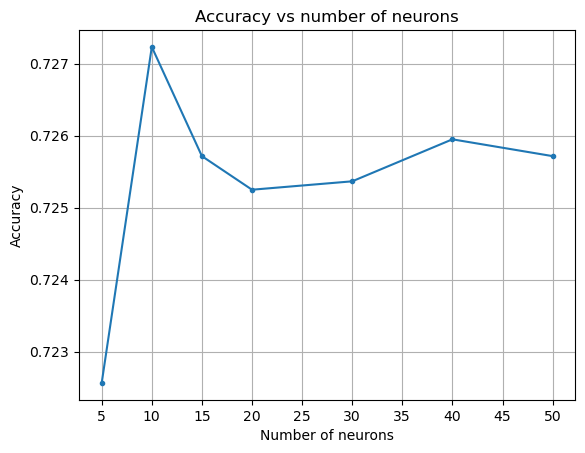

In [40]:
hidden_units = [5, 10, 15, 20, 30, 40, 50]
plt.plot(hidden_units,model_2_3_acc, '.-')
plt.xlabel('Number of neurons')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of neurons')
plt.xticks(list(range(5,55,5)))
plt.grid()
plt.savefig('img/accuracy_vs_number_of_neurons.png')
plt.show()

### Strategy 4: change the number of epochs
Based on the results above, we keep 10 neurons per layer. We now look into the number of epochs that provides the best accuracy.

In [28]:
# Model parameters (fixed)
in_features = len(X.columns)
hidden_layers = 3 # Number of hidden layers
internal_activation = ['selu']*hidden_layers
hidden_units = 10 # Number of neurons per hidden layer
in_units = hidden_units
internal_layers = [hidden_units]*hidden_layers
data_train = {'X': X_train_scaled, 'y': y_train}
data_test = {'X': X_test_scaled, 'y': y_test}

# Model paramters (variable)
n_epochs = [100, 200, 300, 400, 500, 600, 700, 800]

# Create empty list to store results
model_2_4_loss = []
model_2_4_acc = []

for e in n_epochs:
    # Print step
    print(f"Prepare model with {e} epochs...")

    # Train and evaluate model
    loss, acc, model = train_and_evaluate_model(data_train, data_test, in_features, in_units, internal_layers, internal_activation, e)

    # Add performance data to lists
    model_2_4_loss.append(loss)
    model_2_4_acc.append(acc)

Prepare model with 100 epochs...
Prepare model with 200 epochs...
Prepare model with 300 epochs...
Prepare model with 400 epochs...
Prepare model with 500 epochs...
Prepare model with 600 epochs...
Prepare model with 700 epochs...
Prepare model with 800 epochs...


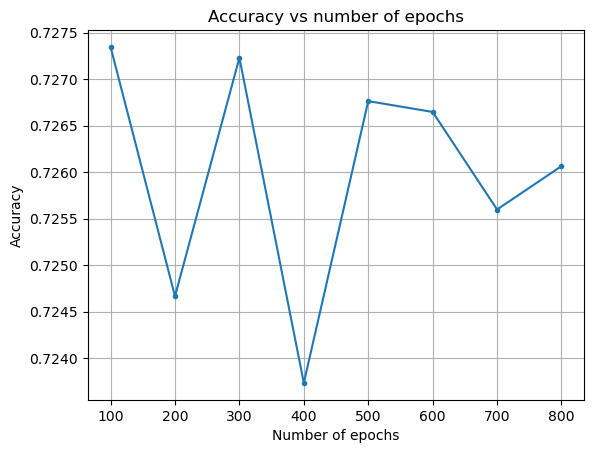

In [41]:
plt.plot(n_epochs,model_2_4_acc, '.-')
plt.xlabel('Number of epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs number of epochs')
plt.grid()
plt.savefig('img/accuracy_vs_number_of_epochs.png')
plt.show()

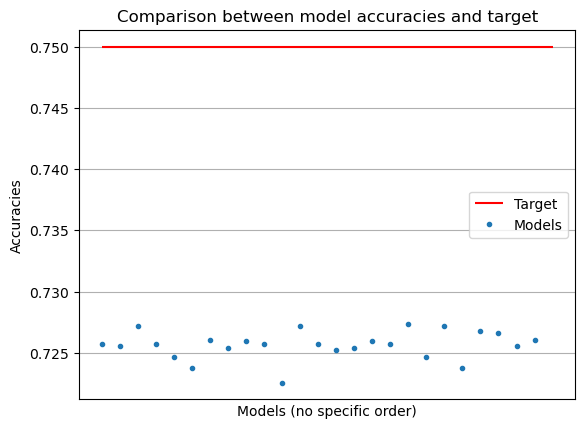

In [79]:
compare_accuracies = model_2_1_acc + model_2_2_acc + model_2_3_acc + model_2_4_acc

plt.hlines(0.75,0,len(compare_accuracies),'r')
plt.plot(compare_accuracies,'.')
plt.grid()
plt.legend(['Target', 'Models'], loc='center right')
plt.xticks([])
plt.xlabel('Models (no specific order)')
plt.ylabel('Accuracies')
plt.title('Comparison between model accuracies and target')
plt.savefig('img/comparison_between_model_accuracies_and_target.png')
plt.show()

In [92]:
# Model performance statistics
from statistics import mean
print(f"Max accuracy: {100*max(compare_accuracies):.2f}%")
print(f"Min accuracy: {100*min(compare_accuracies):.2f}%")
print(f"Avg. accuracy: {100*mean(compare_accuracies):.2f}%")

Max accuracy: 72.73%
Min accuracy: 72.26%
Avg. accuracy: 72.57%


### Optimised model
Based on the results above, we prepare a model with the following parameters:
- 3 hidden layers
- `selu` activation function
- 10 neurons per layer
- 100 epochs

In [70]:
in_units = 10
internal_activation = ['selu']*3
internal_layers = [10]*3
n_epochs = 100

model_2_loss, model_2_acc, model_2 = train_and_evaluate_model(data_train, data_test, in_features, in_units, internal_layers, internal_activation, n_epochs)

In [71]:
print(f"Loss: {100*model_2_loss:.2f}%")
print(f"Accuracy: {100*model_2_acc:.2f}%")

Loss: 55.36%
Accuracy: 72.51%


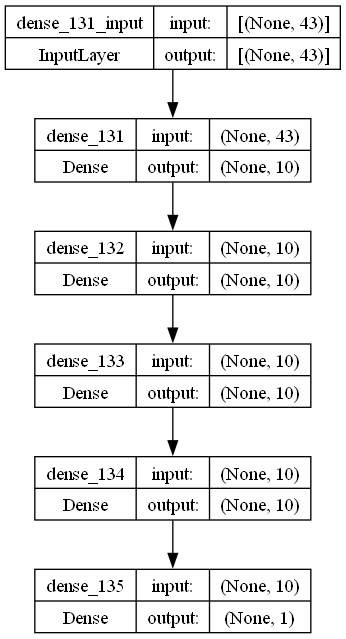

In [93]:
dot_img_file = 'img/model_2.png'
tf.keras.utils.plot_model(model_2, to_file=dot_img_file, show_shapes=True)

## Third model, using Keras tuner

In [12]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):

    input_dim = 43


    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','selu','sigmoid','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=20,
        step=2), activation=activation, input_dim=input_dim))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=20,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [13]:
# Import the kerastuner library
import keras_tuner as kt

tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

Using TensorFlow backend


In [75]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 60 Complete [00h 00m 29s]
val_accuracy: 0.5331778526306152

Best val_accuracy So Far: 0.7285131216049194
Total elapsed time: 00h 11m 14s


In [85]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'first_units': 9,
 'num_layers': 2,
 'units_0': 9,
 'units_1': 17,
 'units_2': 1,
 'units_3': 5,
 'units_4': 13,
 'units_5': 9,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 7,
 'tuner/bracket': 2,
 'tuner/round': 2,
 'tuner/trial_id': '0015'}

In [87]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)

print(f"Loss: {100*model_loss:.2f}%")
print(f"Accuracy: {100*model_accuracy:.2f}%")

268/268 - 0s - loss: 0.5520 - accuracy: 0.7285 - 363ms/epoch - 1ms/step
Loss: 55.20%
Accuracy: 72.85%


In [78]:
# Export the model to HDF5 file
filename = 'AlphabetSoupCharity_Optimisation.h5'
pickle.dump(best_model, open(filename, 'wb'))

# Open pickled model

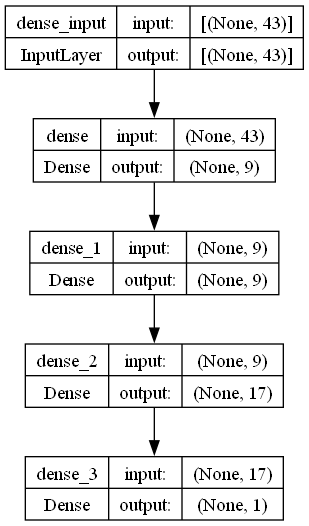

In [94]:
loaded_best_model = pickle.load(open('AlphabetSoupCharity_Optimisation.h5', 'rb'))
dot_img_file = 'img/model_3.png'
tf.keras.utils.plot_model(loaded_best_model, to_file=dot_img_file, show_shapes=True)

# Changing features

In [4]:
# Split our preprocessed data into our features and target arrays
y = concat_df['IS_SUCCESSFUL']
X_2 = concat_df.drop(columns='IS_SUCCESSFUL')

In [8]:
# Calculate the square of the amount asked
X_2['ASK_AMT_SQUARE'] = X_2['ASK_AMT']*X_2['ASK_AMT']

In [11]:
# Split the preprocessed data into a training and testing dataset
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y, random_state=78)

# Create a StandardScaler instances
scaler_2 = StandardScaler()

# Fit the StandardScaler
X_scaler_2 = scaler.fit(X_train_2)

# Scale the data
X_train_scaled_2 = X_scaler_2.transform(X_train_2)
X_test_scaled_2 = X_scaler_2.transform(X_test_2)

In [15]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model2(hp):

    input_dim = 44


    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','selu','sigmoid','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=20,
        step=2), activation=activation, input_dim=input_dim))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=20,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [16]:
tuner_2 = kt.Hyperband(
    create_model2,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

# Run the kerastuner search for best hyperparameters
tuner_2.search(X_train_scaled_2,y_train_2,epochs=20,validation_data=(X_test_scaled_2,y_test_2))

Trial 56 Complete [00h 00m 27s]
val_accuracy: 0.7285131216049194

Best val_accuracy So Far: 0.7285131216049194
Total elapsed time: 00h 10m 26s


In [17]:
# Get best model hyperparameters
best_hyper_2 = tuner_2.get_best_hyperparameters(1)[0]
best_hyper_2.values

{'activation': 'selu',
 'first_units': 5,
 'num_layers': 4,
 'units_0': 19,
 'units_1': 7,
 'units_2': 13,
 'units_3': 5,
 'units_4': 11,
 'units_5': 7,
 'tuner/epochs': 20,
 'tuner/initial_epoch': 0,
 'tuner/bracket': 0,
 'tuner/round': 0}

In [20]:
# Evaluate best model against full test data
best_model_2 = tuner_2.get_best_models(1)[0]
model_2_loss, model_2_accuracy = best_model_2.evaluate(X_test_scaled_2,y_test_2,verbose=2)

print(f"Loss: {100*model_2_loss:.2f}%")
print(f"Accuracy: {100*model_2_accuracy:.2f}%")

268/268 - 0s - loss: 0.5545 - accuracy: 0.7285 - 399ms/epoch - 1ms/step
Loss: 55.45%
Accuracy: 72.85%


## Treat the income as an ordinal feature


In [54]:
X_3 = X_2[:]

In [55]:
X_3['INCOME_AMT'] = application_df['INCOME_AMT']
X_3 = X_3.drop(columns=['INCOME_AMT_0',
 'INCOME_AMT_1-9999',
 'INCOME_AMT_10000-24999',
 'INCOME_AMT_25000-99999',
 'INCOME_AMT_100000-499999',
 'INCOME_AMT_1M-5M',
 'INCOME_AMT_5M-10M',
 'INCOME_AMT_10M-50M',
 'INCOME_AMT_50M+'])

C:\Users\User\AppData\Local\Temp\ipykernel_14384\2248230989.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_3['INCOME_AMT'] = application_df['INCOME_AMT']


In [56]:
X_3.loc[X_3['INCOME_AMT']=='0','INCOME_AMT'] = 0
X_3.loc[X_3['INCOME_AMT']=='1-9999','INCOME_AMT'] = 1
X_3.loc[X_3['INCOME_AMT']=='10000-24999','INCOME_AMT'] = 2
X_3.loc[X_3['INCOME_AMT']=='25000-99999','INCOME_AMT'] = 3
X_3.loc[X_3['INCOME_AMT']=='100000-499999','INCOME_AMT'] = 4
X_3.loc[X_3['INCOME_AMT']=='1M-5M','INCOME_AMT'] = 5
X_3.loc[X_3['INCOME_AMT']=='5M-10M','INCOME_AMT'] = 6
X_3.loc[X_3['INCOME_AMT']=='10M-50M','INCOME_AMT'] = 7
X_3.loc[X_3['INCOME_AMT']=='50M+','INCOME_AMT'] = 8

In [57]:
X_3['INCOME_AMT'].value_counts()

0    24388
3     3747
4     3374
5      955
1      728
2      543
7      240
6      185
8      139
Name: INCOME_AMT, dtype: int64

In [58]:
# Split the preprocessed data into a training and testing dataset
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_3, y, random_state=78)

# Create a StandardScaler instances
scaler_3 = StandardScaler()

# Fit the StandardScaler
X_scaler_3 = scaler_3.fit(X_train_3)

# Scale the data
X_train_scaled_3 = X_scaler_3.transform(X_train_3)
X_test_scaled_3 = X_scaler_3.transform(X_test_3)

In [59]:
len(X_3.columns)

36

In [60]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model3(hp):

    input_dim = 36


    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','selu','sigmoid','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=20,
        step=2), activation=activation, input_dim=input_dim))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=20,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [61]:
tuner_3 = kt.Hyperband(
    create_model3,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2)

# Run the kerastuner search for best hyperparameters
tuner_3.search(X_train_scaled_3,y_train_3,epochs=20,validation_data=(X_test_scaled_3,y_test_3))

Trial 60 Complete [00h 00m 29s]
val_accuracy: 0.7272303104400635

Best val_accuracy So Far: 0.7286297082901001
Total elapsed time: 00h 10m 53s


In [62]:
# Get best model hyperparameters
best_hyper_3 = tuner_3.get_best_hyperparameters(1)[0]
best_hyper_3.values

# Evaluate best model against full test data
best_model_3 = tuner_3.get_best_models(1)[0]
model_3_loss, model_3_accuracy = best_model_3.evaluate(X_test_scaled_3,y_test_3,verbose=2)

print(f"Loss: {100*model_3_loss:.2f}%")
print(f"Accuracy: {100*model_3_accuracy:.2f}%")

268/268 - 0s - loss: 0.5527 - accuracy: 0.7286 - 364ms/epoch - 1ms/step
Loss: 55.27%
Accuracy: 72.86%
